Hi all!
In this script, we use (deep) reinforcement learning to solve the knapsack problem.

What is the knapsack problem (KP)? 
The KP is a problem where you are given a knapsack (a bag) with limited capacity and a set of objets.
Objects have two attributes, prize and weight. Your goal is to select some objects such that you maximize the prize of the object chosen without exceeding the capacity of the knapsack.

For example, given a knapsack of capacity 1 (also in the following, we assume weights to be normalized, so capacity knapsack = 1) and objects [prize, weight] = {[3,0.8],[1,0.25],[1,0.25],[1,0.25],[1,0.25]} the best solution would be to NOT pick up $obj_{0}$ (even if it has the greatest prize) while picking up all the other objects.

Why I've chosen the KP? Because the KP is often considered the easiet among the NP-Hard problem (meaning that it takes exponential number of steps to achieve the optimal solution)

The ingredients of out RL will be the following:
- multi task RL (because every instance is different)
- DQN: deep Q-network
- value approxiamtion via deep NN. Since the solution does not depends on the order of the objects (and for many other reasons), we use the attention mechanism in the NN. Attention is permutation - indifferent.
- off policy. We use eps-greedy to explore but we use greedy to test.

The overall script will be devided in (more or less) five big modules for repetibility usage.
1. environment (generate tasks, new states, rewards,..)
2. replay memory (memorizes transitions)
3. Model (decides the exploration/evaluation policy)
4. Learner (updates the model. input: memory, model)
5. Runner (runs episodes. input: environment, model)

a sixth module for printing is present, but that does not affect the overall algorithm.

As always, we start by importing useful libraries

In [1]:
import matplotlib.pyplot as plt

import numpy as np 
import pandas as pd
import torch 
import random
import itertools
import copy
import time 
#from queue import Queue # for the buffer; no! you can't random.sample on this
from collections import deque # for the buffer
try:
    import cPickle as pickle
except ModuleNotFoundError:
    import pickle

%matplotlib inline

random.seed(1234)

import torch
if torch.cuda.is_available():
    print('GPU')

Then we define the first big module: ENVIRONMENT
- the environment generates a task with num_objs (input) objects. 
- the enviroment can either generate a real instance (by default) or a fake one of which we know the optimal solution.
- the environment returns the objects and their target (which is computed via an heuristic). # CHANGE THIS

NOTE! for some aspects, what we call environment is actually more a task than an environment.

In [2]:
class ObjectCass:
    
    Prize = None
    Weight = None
    
    def __init__(self, reward, weight):
        
        self.Prize = reward
        self.Weight = weight

class StateClass:
    
    ObjectsFeatures = None
    res_capacity = None
    Chosen = None
    price = None
    Final = None
    IndexesActionsNotMasked = None
    
    def __init__(self, ObjectsFeatures, res_capacity, Chosen, price, Task):
        
        self.res_capacity = res_capacity
        self.Chosen = Chosen
        self.price = price
        self.Final = 0
        self.IndexesActionsNotMasked = self.StateMaskFunction(Task)
        if len(self.IndexesActionsNotMasked)==0:
            self.Final=1
        self.ObjectsFeatures = ObjectsFeatures
        # change the boolean feature of the not selectable actions
        for i in range(len(self.ObjectsFeatures)):
            if i not in self.IndexesActionsNotMasked:
                self.ObjectsFeatures[i][2]=0.0
        
        return

    def StateMaskFunction(self, Task):
        
        indexes = [i for i in range(len(Task.Objects)) 
                    if i not in self.Chosen and 
                    not (self.res_capacity - Task.Objects[i].Weight < 0)]
    
        return indexes 
    
class TaskClass:
    
    Objects = None
    total_capacity = None
    target = None
    
    def __init__(self, Objects, total_capacity):
        
        self.Objects = Objects
        self.total_capacity = total_capacity
        self.target = self.Heuristic(Objects)

    def Heuristic(self, Objects):
    
        Objects_sorted = sorted(Objects, key=lambda obj: -float(obj.Prize)/obj.Weight)
        weight_total = 0
        price_total = 0
        for obj in Objects_sorted:
            if weight_total+obj.Weight>1:
                continue
            price_total+=obj.Prize
            weight_total+=obj.Weight

        target = torch.tensor(price_total).float()
        target.requires_grad = False

        return target
    
    def initial_state(self):
        
        price = torch.tensor(0).float() #
        
        ObjectsFeatures = []
        for i in range(len(self.Objects)):
            ObjectsFeatures.append(torch.tensor([self.Objects[i].Prize, self.Objects[i].Weight, 1.0 , self.total_capacity]))
        ObjectsFeatures = torch.stack(ObjectsFeatures) 
        
        return StateClass(ObjectsFeatures, self.total_capacity, [], price, self)
    
    def step(self, state_old, action):
    
        capacity = state_old.res_capacity-self.Objects[action].Weight
        price = state_old.price+self.Objects[action].Prize
        New_Chosen = copy.copy(state_old.Chosen)
        New_Chosen.append(action)
        ObjectsFeatures = state_old.ObjectsFeatures.clone()
        for i in range(len(ObjectsFeatures)):
            ObjectsFeatures[i][-1] = capacity
        # the boolens of the unchosable objects will be set to zero with the following command
        state_new = StateClass(ObjectsFeatures, capacity, New_Chosen, price, self)
        
        # new state , reward
        return state_new, self.Objects[action].Prize

class EnvironmentClass:
    
    num_objs = None
    
    def __init__(self, num_objs):
        
        self.num_objs = num_objs
        
        return
    
    def NewTask(self, FakeBool = False, prize_min=0.01, prize_max=1, weight_min=0.01, weight_max=1, shuffle = False):
  
        if FakeBool:
            # fake task
            # best solution = [1,0,1,0,1,0,1,0,1,0,1]
            Objects = []
            for i in range(self.num_objs):
                if i%2==1:
                    prize = 0.1
                    weight = 0.99
                    obj = ObjectCass(prize,weight)
                    Objects.append(obj)
                else:
                    prize = 1
                    weight = (2/float(num_objs))-0.001
                    obj = ObjectCass(prize,weight)
                    Objects.append(obj)
            if shuffle:
                random.shuffle(Objects)

        else:
            Objects = []
            for i in range(self.num_objs):
                prize = round(random.uniform(prize_min, prize_max), 2)
                weight = round(random.uniform(weight_min, weight_max), 2)
                obj = ObjectCass(prize,weight)
                Objects.append(obj)

        capacity = torch.tensor([1]).float() #

        self.Objects = Objects
        self.capacity = capacity
            
        return TaskClass(Objects, capacity)   
    
    def InitialStateNewTask(self, FakeBool = False, prize_min=0.01, prize_max=1, weight_min=0.01, weight_max=1, shuffle = False):
        
        Task = self.NewTask(FakeBool = False, prize_min=0.01, prize_max=1, weight_min=0.01, weight_max=1, shuffle = False)
        initial_state = Task.initial_state()
        
        return initial_state, Task
    

env = EnvironmentClass(2)
s_0, task = env.InitialStateNewTask()
s_1, reward = task.step(s_0,0)
print('s_0 cap', s_0.res_capacity)
print('s_1 cap', s_1.res_capacity)
print('s_0 total reward', s_0.price)
print('s_1 total reward', s_1.price)
print('s_0 obj features', s_0.ObjectsFeatures)
print('s_1 obj features', s_1.ObjectsFeatures)
print('reward', reward)

('s_0 cap', tensor([1.]))
('s_1 cap', tensor([0.5500]))
('s_0 total reward', tensor(0.))
('s_1 total reward', tensor(0.9700))
('s_0 obj features', tensor([[0.9700, 0.4500, 1.0000, 1.0000],
        [0.0200, 0.9100, 1.0000, 1.0000]]))
('s_1 obj features', tensor([[0.9700, 0.4500, 0.0000, 0.5500],
        [0.0200, 0.9100, 0.0000, 0.5500]]))
('reward', 0.97)


Implementation based on: https://towardsdatascience.com/understanding-actor-critic-methods-931b97b6df3f

Second big module: Model
- the model contains the training/evaluation policy and it is responsable for choosing the actions
- it contains the NN used for value function approximation

In [3]:
class Net_Attention(torch.nn.Module):
    
    def __init__(self, num_input_features,h_model, num_head ,num_layers, dim_feedforward, p_dropout, num_outputs):    
        
        super(Net_Attention, self).__init__()
        
        self.emb = torch.nn.Linear(num_input_features,  h_model)
        #encoder_layer = torch.nn.TransformerEncoderLayer(d_model=h_model, nhead=num_head, 
        #                                           dim_feedforward=dim_feedforward, dropout=p_dropout)
        #self.transformer_encoder = torch.nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        #        
        # FINAL LAYER
        #self.final_layer_0 = torch.nn.Linear(h_model,h_model)
        self.final_layer_1 = torch.nn.Linear(h_model,1)

    def forward(self, States, no_grad = False):
        
        ObjectsFeatures = [state.ObjectsFeatures for state in States]
        ObjectsFeatures = torch.stack(ObjectsFeatures)
        
        # define relu operation
        ReLU = torch.nn.ReLU()
        
        if no_grad: #doesn't compute the gradients (hence no back propagation, but faster). 
            with torch.no_grad(): # to be used only in evaluations and target (not in training the prediction)        
                E = self.emb(torch.transpose(ObjectsFeatures,0,1))
                c = E
                # where 
                # S is the source sequence length,  
                # N is the batch size,  
                # E is the feature number        
                # you want 
                # E.size() = S,N,E = num_obj x batch x h_model
                #c = self.transformer_encoder(E)
                #c = self.final_layer_0(c)
                #c = ReLU(c)
                Qvals = self.final_layer_1(c)
                Qvals = torch.squeeze(Qvals, dim = 2)
                Qvals = torch.transpose(Qvals,0,1)
                
                return Qvals
            
        E = self.emb(torch.transpose(ObjectsFeatures,0,1))
        c = E
        # where 
        # S is the source sequence length,  
        # N is the batch size,  
        # E is the feature number        
        # you want 
        # E.size() = S,N,E = num_obj x batch x h_model
        #c = self.transformer_encoder(E)
        #c = self.final_layer_0(c)
        c = ReLU(c)
        Qvals = self.final_layer_1(c)
        Qvals = torch.squeeze(Qvals, dim = 2)
        Qvals = torch.transpose(Qvals,0,1)
        #print(Qvals.size())
                
        return Qvals

class ModelClass():

    def __init__(self, Net_current, Net_target, training_policy, evaluation_policy, epsilon_max, epsilon_min):
        
        self.Net_current = Net_current
        self.Net_target  = Net_target
        if training_policy!='eps-greedy' or evaluation_policy!='greedy':
            print('at least one of this exploration/evaluation policy are still to implement')
            error
        else:
            self.epsilon_min = epsilon_min
            self.epsilon_max = epsilon_max
        self.training_policy   = training_policy
        self.evaluation_policy = evaluation_policy

    def Greedy(self, Qvals, state):
        
        Qvals_selectable = [Qvals[i] for i in range(len(Qvals)) if i in state.IndexesActionsNotMasked]
        Qvals_selectable = torch.stack(Qvals_selectable)
        action = torch.argmax(Qvals_selectable)
        action_index = state.IndexesActionsNotMasked[action]

        return action_index
    
    def EpsGreedy(self, Qvals,state, iteration_counter, num_iterations):
    
        # select action
        epsilon = (epsilon_max-epsilon_min)*(num_iterations-iteration_counter)/num_iterations + epsilon_min
        if random.random() < epsilon:
            action_index = random.choice(state.IndexesActionsNotMasked)
        else:
            action_index = self.Greedy(Qvals,state)

        return action_index
    
    def training_step(self, state, iteration_counter, num_iterations):

        self.Net_current.train()
        if self.training_policy == 'eps-greedy':
            Qvals = self.Net_current([state])
            Qvals = Qvals.squeeze()
            return self.EpsGreedy(Qvals, state, iteration_counter, num_iterations)
        error
    
    def evaluation_step(self, state):
        
        self.Net_current.eval()
        if self.evaluation_policy == 'greedy':
            Qvals = self.Net_current([state], no_grad = True)
            Qvals = Qvals.squeeze()
            return self.Greedy(Qvals, state)
        error

Now we have a function that, given a state, it returns the Q values. We have to define the loss 

Third module: BUFFER (aka replay memory)
- the buffer contains the last #replay_lenght transictions.
- each experience in the buffer is as a tuple <$s_{old}$, action, r, $s_{new}$>

In [4]:
class ReplayMemoryClass:
    
    replay_lenght = None
    minibatch_size = None
    Buffer = None
    new_transitions = None
    
    def __init__(self,replay_lenght, minibatch_size):
        
        self.replay_lenght = replay_lenght
        self.minibatch_size = minibatch_size
        self.Buffer = []
        self.new_transitions = 0
        
    def Add(self, Transitions):
                
        while len(self.Buffer)+len(Transitions)>=self.replay_lenght:
            self.Buffer.remove(self.Buffer[0])
        for t in Transitions:
            self.Buffer.append(t)
        self.new_transitions+=len(Transitions)
        
        return
        
    def Minibatch(self):
        
        if len(self.Buffer) <= self.minibatch_size:
            Minibatch = self.Buffer
            self.new_transitions = max(0, self.new_transitions-len(self.Buffer))
        else:
            if self.new_transitions == 0: # no priority
                Minibatch = random.sample(self.Buffer, self.minibatch_size)
            else:
                new_transitions = min(self.new_transitions, self.minibatch_size)
                Minibatch_new_transitions = [self.Buffer[i] 
                                             for i in range((len(self.Buffer)-new_transitions)
                                                            ,(len(self.Buffer)))]
                remaining_transitions = min(0, self.minibatch_size - new_transitions)
                Minibatch_random = random.sample(self.Buffer, remaining_transitions)
                Minibatch = Minibatch_new_transitions + Minibatch_random
                self.new_transitions-=new_transitions
                
        # CHANGE THE WAY YOU SAVE THINFS IN THE BUFFER!!!!
        # SAVE DIRECTLY AS THE LISTS BELOW
                
        States = [experience[0] for experience in Minibatch]
        Actions = [experience[1] for experience in Minibatch]
        Rewards = [experience[2] for experience in Minibatch]
        New_States = [experience[3] for experience in Minibatch]
        
        Minibatch = [States, Actions, Rewards, New_States]
        
        return Minibatch

Fourth module: LEARNER
- receives minibatches
- updates the Model

In [5]:
class LearnerClass():

    Model = None
    optimizer = None
    gamma = None
    tau = None
    
    def __init__(self,Model, optimizer, tau, gamma=1):
        
        self.Model = Model
        self.optimizer = optimizer
        self.tau = tau
        self.gamma = gamma

    def Learning_step(self, Minibatch):
                
        # zero the gradient buffers
        self.optimizer.zero_grad() 
        
        Losses = []
        States, Actions, Rewards, New_States = Minibatch
        
        New_States_Target = [New_States[i] for i in range(len(New_States)) if New_States[i].Final==0]
        if len(New_States_Target)>0:
            _, indexes = torch.max(self.Model.Net_target(New_States_Target, no_grad = True), dim = 1)
            Qvals_new_states = self.Model.Net_current(New_States_Target)
            Max_New_States_Target = [Qvals_new_states[i][indexes[i]] for i in range(len(Qvals_new_states))]
        else:
            Max_New_States_Target = []
        Max_New_States = []
                
        j = 0
        for i in range(len(New_States)):
            if New_States[i].Final==0: # not final
                Max_New_States.append(Max_New_States_Target[j])
                j+=1
            else:
                zero_tensor_scalar = torch.tensor(0).float()
                zero_tensor_scalar.requires_grad = False
                Max_New_States.append(zero_tensor_scalar)
                
        Max_New_States = torch.stack(Max_New_States)
        Rewards = torch.tensor(Rewards)
        Current_States_Prediction = self.Model.Net_current(States)
        Predictions_Actions = [Current_States_Prediction[i][Actions[i]] for i in range(len(Current_States_Prediction))]
        Predictions_Actions = torch.stack(Predictions_Actions)
        
        #Losses = (Rewards + self.gamma*Max_New_States - Predictions_Actions)**2 
        #loss = Losses.mean()
        
        loss_method = torch.nn.MSELoss( reduction = 'mean')
        loss = loss_method(Predictions_Actions,Rewards + self.gamma*Max_New_States)
        
        time_start = time.clock()
        loss.backward()
        time_backward = time.clock()-time_start
        
        # gradient clipping
        clip_value = 1
        grad_norm = torch.nn.utils.clip_grad_norm_(self.Model.Net_current.parameters(), clip_value)
        
        # apply gradient
        self.optimizer.step()

        # soft target update
        for param_target, param_current in zip(self.Model.Net_target.parameters(), self.Model.Net_current.parameters()):
            param_target.data.copy_(param_target.data * (1.0 - self.tau) + param_current.data * self.tau)        
        
        return loss.tolist(), time_backward

Fifth module: RUNNER
- takes the environment and the module
- runs a transaction. Or should it run an episode?

In [6]:
class RunnerClass():

    Environment = None
    Model = None
    
    def __init__(self, Environment, Model):
        
        self.Model = Model
        self.Environment = Environment
        
    def NewTrainingTask(self, iteration_counter,num_iterations):
        
        Transitions = []
        state, task = self.Environment.InitialStateNewTask()
        G = 0 # reward obtained
        while state.Final == 0:
            action_index = self.Model.training_step(state, iteration_counter,num_iterations)
            new_state, reward = task.step(state, action_index)
            G+=reward
            Transitions.append([state, action_index, reward, new_state])
            state = new_state
         
        return Transitions, task.target, G
    
    def NewEvaluationTask(self):
        
        state, task = self.Environment.InitialStateNewTask()
        G = 0
        while state.Final == 0:
            action_index = self.Model.evaluation_step(state)
            new_state, reward = task.step(state, action_index)
            G+=reward
            state = new_state
         
        return G, task.target

Now we create a function to evaluate the trained network

In [7]:
def Evaluate(num_iterations, Runner):
    
    better = 0
    G_tot = []
    heuristic_tot = []
    for iteration_counter in range(num_iterations):
        # perform new task
        G, heuristic = Runner.NewEvaluationTask()
        G_tot.append(G)
        heuristic_tot.append(heuristic)
        if G >= heuristic:
            better+=1
    print('the NN was better than (or equal to) the heuristic '+str(better)+' times out of '+str(num_iterations)) 
    
    R_norm = [G_tot[i]/heuristic_tot[i] for i in range(len(G_tot))]
    mean = np.mean(R_norm)
    std = np.std(R_norm)
    
    return mean, std

and we also define a function to print stuff.
(this function is not really smart, it recomputes the Q values. think of another way to do it)

In [8]:
class StuffToBePrintedClass():
    
    Initial_Qvals = None
    Gs = None
    heuristic_targets = None
    PATH = None
    Evaluation = None
    loss = None

    def __init__(self, path, Initial_Qvals=[], Gs=[], heuristic_targets=[], Evaluation=[], loss=[]):
        
        self.PATH = path
        self.Initial_Qvals = Initial_Qvals
        self.Gs = Gs
        self.heuristic_targets = heuristic_targets
        self.Evaluation = Evaluation
        self.loss = loss
    
    def AddElements(self,Initial_Qvals='dummy', G='dummy', backwards_time='dummy', heuristic_target='dummy'
                   , Evaluation='dummy', loss='dummy'):
        
        """ comment what it does.
        """
        
        if Initial_Qvals!='dummy':
            self.Initial_Qvals.append(Initial_Qvals)
        if G!='dummy':
            self.Gs.append(G)
        if heuristic_target!='dummy':
            self.heuristic_targets.append(heuristic_target)
        if Evaluation!='dummy':
            self.Evaluation.append(Evaluation)
        if loss!='dummy':
            self.loss.append(loss)
            
        if G!='dummy' and Evaluation!='dummy':
            error
        
        return
    
    def Print(self):
        
        self.PrintSequence(self.Initial_Qvals, 'Initial Qvals', Q_valsBool = True)
        Q_Actions_norm = []
        for i in range(len(self.Initial_Qvals)):
            Q_Action_i = [self.Initial_Qvals[i][j]/self.heuristic_targets[i] for j in range(len(self.Initial_Qvals[i]))]
            Q_Actions_norm.append(Q_Action_i)
        self.PrintSequence(Q_Actions_norm, 'Initial Qvals Normalized', Q_valsBool = True, Ones = True)
        self.PrintSequence(self.Gs, 'Total Rewards', y_min = 0)
        Gs_norm = [self.Gs[i]/self.heuristic_targets[i] for i in range(len(self.Gs))]
        self.PrintSequence(Gs_norm, 'Total Rewards Normalized', Ones = True, y_min = 0)
        self.PrintSequence(self.loss, 'loss', y_min = 0)
        # Evaluation
        self.PrintEvaluation()
        
        return
    
    def PrintSequence(self, sequence, string, Q_valsBool = False, Ones = False, y_min = False):
        
        plt.figure()
        x_axis = [i for i in range(len(sequence))]
        if not Q_valsBool:
            if len(sequence)>100:
                means, stds, x_axis = self.MeanAndStandard(sequence) 
                plt.errorbar(x_axis, means, yerr=stds, label=string) #, fmt='o' if you want the ball 
                #plt.plot(x_axis, means, label=string)
            else:
                plt.plot(sequence, label=string)
        else:
            if len(sequence)>100:
                for i in range(len(sequence[0])):
                    Q_Action_i = [sequence[j][i] for j in range(len(sequence))]
                    means, stds, x_axis = self.MeanAndStandard(Q_Action_i)   
                    plt.errorbar(x_axis, means, yerr=stds, label=string+'_act_'+str(i)) # fmt='o'
                    #plt.plot(x_axis, means, label=string+'_act_'+str(i))
                Q_max = [max(Q_vals) for Q_vals in sequence]
                means, stds, x_axis = self.MeanAndStandard(Q_max)                
                #plt.plot(x_axis, means, label='Q_Max')
                plt.errorbar(x_axis, means, yerr=stds, label='Q_Max') #, fmt='o'
            else:
                for i in range(len(sequence[0])):
                    Q_Action_i = [sequence[j][i] for j in range(len(sequence))]
                    plt.plot(Q_Action_i, label=string+'_act_'+str(i))
                Q_max = [max(Q_vals) for Q_vals in sequence]
                plt.plot(Q_max, label='Q_Max')
        if Ones:
            Ones = [1 for j in range(len(x_axis))]
            plt.plot(x_axis, Ones)
        if y_min:
            plt.ylim(ymin=y_min)
        plt.legend()
        plt.savefig(self.PATH+string+'.png', bbox_inches='tight')
        
        return
    
    def MeanAndStandard(self, sequence):                
        
        unit = int(len(sequence)/100)
        Means = []
        STD = []
        Aux = []
        for i in range(len(sequence)):
            Aux.append(sequence[i])
            if i%unit==0 and i!=0:
                vector = np.array(Aux, dtype=float)
                mean = np.mean(vector)
                std = np.std(vector)
                Means.append(mean)
                STD.append(std)
                Aux = []
        x_axis = [i*unit for i in range(len(Means))]
        
        return Means, STD, x_axis

    def PrintEvaluation(self):

        plt.figure()
        means  = [single_evaluation[0] for single_evaluation in self.Evaluation]
        stds   = [single_evaluation[1] for single_evaluation in self.Evaluation]
        x_axis = [single_evaluation[2] for single_evaluation in self.Evaluation]

        plt.errorbar(x_axis, means, yerr=stds,fmt='o-') # 
        plt.ylabel(' Rewards (normalized) during evaluation ' )
        plt.legend()
        plt.ylim(bottom=0)
        Ones = [1 for j in range(len(x_axis))]
        plt.plot(x_axis, Ones)
        
        plt.savefig(self.PATH+'Evaluation_Normalized_Rewards_per_iteration.png', bbox_inches='tight')

def MaxInitialQvalues(Transitions, Net_predict):
    
    first_state, action_index, reward, new_state = Transitions[0]
    Qvals = Net_predict([first_state], no_grad = True)
    Qvals = Qvals.squeeze().tolist()
    
    return Qvals

The next cell contains functions to save and load the data.
The idea is to save data during training in PATH_AUX
and save data after training in PATH_Final

In [9]:
def SaveData(iteration_counter,Learner,Runner,ReplayMemory,StuffToBePrinted, PATH_save):
    
    with open(PATH_save+'RLKP-num_iterations_start-Save.pkl', 'wb') as output:
        pickle.dump(iteration_counter, output, pickle.HIGHEST_PROTOCOL)
    with open(PATH_save+'RLKP-Learner-Save.pkl', 'wb') as output:
        pickle.dump(Learner, output, pickle.HIGHEST_PROTOCOL)
    with open(PATH_save+'RLKP-Runner-Save.pkl', 'wb') as output:
        pickle.dump(Runner, output, pickle.HIGHEST_PROTOCOL)
    with open(PATH_save+'RLKP-ReplayMemory-Save.pkl', 'wb') as output:
        pickle.dump(ReplayMemory, output, pickle.HIGHEST_PROTOCOL)
    with open(PATH_save+'RLKP-StuffToBePrinted-Save.pkl', 'wb') as output:
        pickle.dump(StuffToBePrinted, output, pickle.HIGHEST_PROTOCOL)
    
    return

def LoadData(Path_load):
    
    with open(Path_load+'RLKP-num_iterations_start-Save.pkl', 'rb') as input:
        num_iterations_start = pickle.load(input)
    with open(Path_load+'RLKP-Learner-Save.pkl', 'rb') as input:
        Learner = pickle.load(input)
    with open(Path_load+'RLKP-Runner-Save.pkl', 'rb') as input:
        Runner = pickle.load(input)
    env = Runner.Environment
    Model = Learner.Model
    Runner.Model = Model
    with open(Path_load+'RLKP-ReplayMemory-Save.pkl', 'rb') as input:
        ReplayMemory = pickle.load(input)
    with open(Path_load+'RLKP-StuffToBePrinted-Save.pkl', 'rb') as input:
        StuffToBePrinted = pickle.load(input)
        
    return num_iterations_start, Learner, Runner, env, Model, ReplayMemory, StuffToBePrinted

Now we create our 5 modules (or load them from existing ones)

In [10]:
# seed
random.seed(1234)
# num episode to be generated
num_iterations = int(5e4)
# num object per episode
num_objs = 10
num_input_features = 4 # prize, weight, res_capacity, Bool_alreday_chosen
num_outputs = num_objs
# transformer details
h_model = 16
num_head = 4
num_layers = 2
dim_feedforward = h_model
p_dropout = 0.0
# minimum and maximum epsilon value
epsilon_max = 1
epsilon_min = 0.05
# how many transiction can you store in the buffer
replay_lenght = 1e6
# minibatch dimension
minibatch_size = 4
# how many times do you want to evaluate the algorithm mid-traing?
unit_evaluation = 10
unit_evaluation = int(num_iterations/unit_evaluation)
# soft update
tau = 0.005
# paths
PATH = '/Users/BigBamboo/Desktop/RL for the KP/'
PATH_Aux = PATH+'Saved_objects_Aux/'
PATH_Final = PATH+'Final_Objects/'

# is it a new test?
LoadTest = False
# objects in the middel of training (Aux) or completely computed (Final)
Path_load = PATH_Aux
if LoadTest:
    num_iterations_start, Learner, Runner, env, Model, ReplayMemory, StuffToBePrinted = LoadData(Path_load)
else:
    # environment
    env = EnvironmentClass(num_objs)
    # model
    Net_current = Net_Attention(num_input_features,h_model, num_head ,num_layers, dim_feedforward, p_dropout, num_outputs)
    Net_target  = Net_Attention(num_input_features,h_model, num_head ,num_layers, dim_feedforward, p_dropout, num_outputs)
    Model = ModelClass(Net_current, Net_target, 'eps-greedy', 'greedy', epsilon_max, epsilon_min)
    # Replay Memory
    ReplayMemory = ReplayMemoryClass(replay_lenght, minibatch_size)
    # Learner
    optimizer = torch.optim.RMSprop(Net_current.parameters())#, lr=learning_rate)
    Learner = LearnerClass(Model, optimizer, tau)
    # Runner
    Runner = RunnerClass(env, Model)
    # print
    StuffToBePrinted = StuffToBePrintedClass(PATH_Final, [], [], [], [], [])    
    # zero if you start a new test
    num_iterations_start = 0

And now we use them.

/Users/BigBamboo/anaconda/lib/python2.7/site-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


('task number: ', 0)
the NN was better than (or equal to) the heuristic 66 times out of 100
('task number: ', 500)
('task number: ', 1000)
('task number: ', 1500)
('task number: ', 2000)
('task number: ', 2500)
('task number: ', 3000)
('task number: ', 3500)
('task number: ', 4000)
('task number: ', 4500)
('task number: ', 5000)
the NN was better than (or equal to) the heuristic 46 times out of 100
('task number: ', 5500)
('task number: ', 6000)
('task number: ', 6500)
('task number: ', 7000)
('task number: ', 7500)
('task number: ', 8000)
('task number: ', 8500)
('task number: ', 9000)
('task number: ', 9500)
('task number: ', 10000)
the NN was better than (or equal to) the heuristic 40 times out of 100
('task number: ', 10500)
('task number: ', 11000)
('task number: ', 11500)
('task number: ', 12000)
('task number: ', 12500)
('task number: ', 13000)
('task number: ', 13500)
('task number: ', 14000)
('task number: ', 14500)
('task number: ', 15000)
the NN was better than (or equal to)

/Users/BigBamboo/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


.. end printing


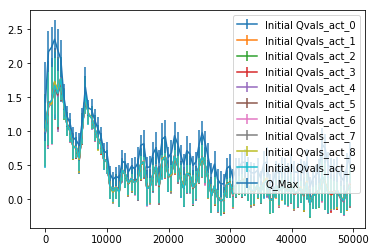

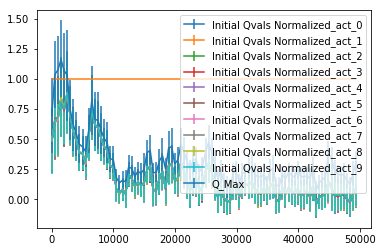

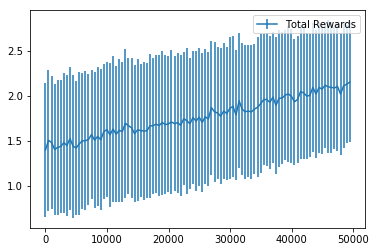

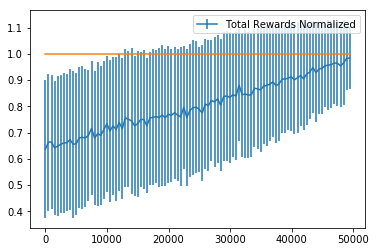

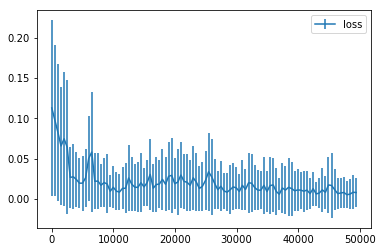

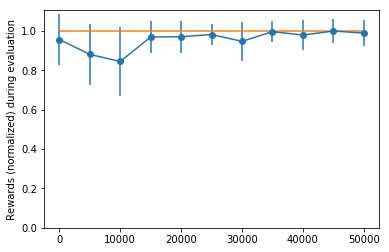

In [11]:
for iteration_counter in range(num_iterations_start, num_iterations):
    if iteration_counter%500==0:
        SaveData(iteration_counter,Learner,Runner,ReplayMemory,StuffToBePrinted, PATH_Aux)
        print('task number: ',(iteration_counter))
    # perform new task
    Transitions, target_heuristic, G = Runner.NewTrainingTask(iteration_counter, num_iterations)
    # save transition
    ReplayMemory.Add(Transitions)
    # learn        
    if iteration_counter>= ReplayMemory.minibatch_size:
        loss, time_backwards = Learner.Learning_step(ReplayMemory.Minibatch())
        StuffToBePrinted.AddElements(Initial_Qvals = MaxInitialQvalues(Transitions, Model.Net_current), 
                                     G = G, backwards_time = time_backwards,
                                     heuristic_target = target_heuristic, loss = loss)
    # evaluate mid-training
    if iteration_counter%unit_evaluation == 0:
        mean, std = Evaluate(100, Runner)
        StuffToBePrinted.AddElements(Evaluation = [mean, std, iteration_counter])

# evaluate after training
mean, std = Evaluate(100, Runner)
StuffToBePrinted.AddElements(Evaluation = [mean, std, iteration_counter])
# save data
SaveData(num_iterations,Learner,Runner,ReplayMemory,StuffToBePrinted, PATH_Final)
# print
print('printing..')
StuffToBePrinted.Print()
print('.. end printing')

In [13]:
# is it a new test?
LoadTest = True
# objects in the middel of training (Aux) or completely computed (Final)
Path_load = PATH_Aux
Path_load = PATH_Final
if LoadTest:
    num_iterations_start, Learner, Runner, env, Model, ReplayMemory, StuffToBePrinted = LoadData(Path_load)
mean, std = Evaluate(100, Runner)
print('average normalized return; ', mean)
print('with standard deviation ; ', std)

the NN was better than (or equal to) the heuristic 88 times out of 100
('average normalized return; ', 0.983478)
('with standard deviation ; ', 0.065795094)


TO DO:
- why double Q learning still overshoots?
- print more stuff (see paper)???
- better heuristic / optimal solutions
- look more into: naming conventions for python

WRITING TIPS (https://www.python.org/dev/peps/pep-0008/#documentation-strings):
- comment what the function does

PERFORMANCE:
- look into gather, stop making lists out of tensors